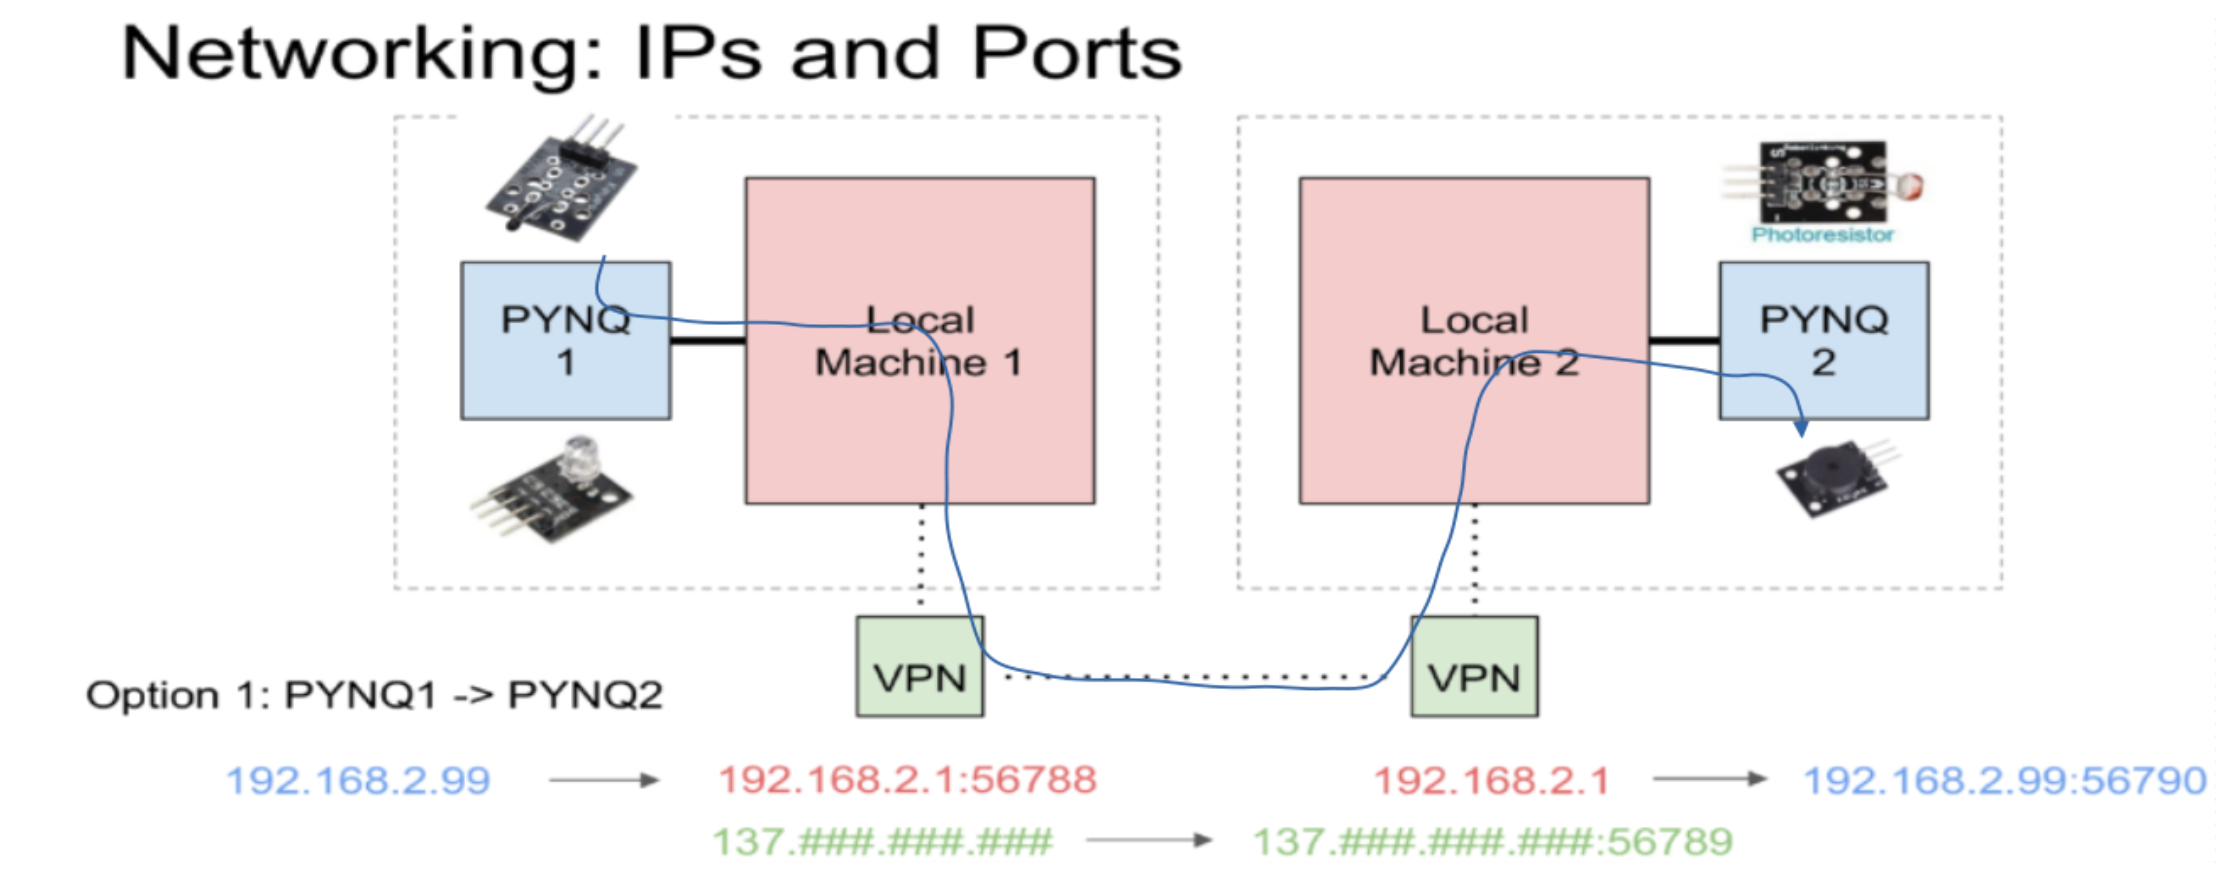

# PYNQ 2 as server, buzzer

In [1]:
# Photoresistor to LED (Red dash line)
import multiprocessing
import threading
import time
import socket
import os
import random
import asyncio  #asyncio is often a perfect fit for IO-bound and high-level structured network code 

from pynq.overlays.base import BaseOverlay
base = BaseOverlay("base.bit")
btns = base.btns_gpio

In [2]:
%%microblaze base.PMODB

#include "gpio.h"
#include "pyprintf.h"

//Function to turn on/off a selected pin of PMODB
void write_gpio(unsigned int pin, unsigned int val){
    if (val > 1){
        pyprintf("pin value must be 0 or 1");
    }
    gpio pin_out = gpio_open(pin);
    gpio_set_direction(pin_out, GPIO_OUT);
    gpio_write(pin_out, val);
}

//Function to read the value of a selected pin of PMODB
unsigned int read_gpio(unsigned int pin){
    gpio pin_in = gpio_open(pin);
    gpio_set_direction(pin_in, GPIO_IN);
    return gpio_read(pin_in);
}

In [3]:
cond = True
#start = 0
buz_int, fInt = 4095, 4095
thresh_L, thresh_M, thresh_H = 1000, 2000, 3000

def setAllOff():
    for i in range(0, 8):
        write_gpio(i, 0)

async def runBuzzer(rt, f):
    global buz_int, cond, start
    while cond:
        await asyncio.sleep(0.1)
        #print('Here buz_int', buz_int)
        if buz_int <= thresh_L:      # no buzzing
            continue
            #setAllOff()
        
        else:
            #buz_int = 4095
            fL = int(f * (buz_int/fInt))       # linear interpolation of frequency
            T = 1/fL # period
            maxCnt = int(rt / T) # number of period
            interval = 1/(2*fL)
        
            write_gpio(3, 1)                  #  middle pin power  (3.3V)
            cnt = 0
            print('running ', maxCnt * 2 * interval, ' sec\n',
                  'max count: ', maxCnt, 
                  'period: ', 2 * interval)
            while (cnt<maxCnt):
                cnt += 1
                write_gpio(2, 1)              # ‘+’ pin, signal you want to write   
                await asyncio.sleep(interval)
                write_gpio(2, 0)
                await asyncio.sleep(interval)
                
            await asyncio.sleep(1)
            buz_int = 0    
            setAllOff()

    
def setBuzzer(rt, f):
    global cond
    T = 1/f # period
    maxCnt = int(rt / T) # number of period 
    interval = 1/(2*f)
    print('running ', maxCnt * 2 * interval, ' sec\n',
          'max count: ', maxCnt, 
          'period: ', 2 * interval)

    write_gpio(3, 1)                  #  middle pin power  (3.3V)
    cnt = 0
    while (cnt<maxCnt):
    #while(cond):
        cnt+=1
        write_gpio(2, 1)              # ‘+’ pin, signal you want to write   
        time.sleep(interval)
        write_gpio(2, 0)
        time.sleep(interval)
   
    print('done, buzzer is off...')
    setAllOff()
            
async def get_btns(_loop):
    global cond, start
    while cond:
        await asyncio.sleep(0.01)
          
        if btns.read() == 8: #stop buzzing
            cond = False
            await asyncio.sleep(0.3)
            print("pressing BTN3, stop buzzing")
            _loop.stop()

In [4]:
setAllOff()

In [5]:
def runBuzzerOperation(rt, f):
    loop = asyncio.new_event_loop()    # Create and return a new event loop object.
    loop.create_task(runBuzzer(rt, f)) # blink the LED’s  in intervals of 1 second (i.e. 1 second on, 1 second off)
    loop.create_task(get_btns(loop))
    loop.run_forever()
    loop.close()

# unit test
rt, f= 5, 80  #rt: run time (sec), f: tone_freq (Hz)
runBuzzerOperation(rt, f)

In [6]:
procs = []      # process
cond = True

def runServer(i_cpu, port):
    global cond, buz_int
    """
    see async def operation(rt, f) above
    cond    condition for loop
    buz_int intensity of photoresistor
    """
    print("Server running on CPU_{} at port {}...\n".format(i_cpu, port))
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

    # 1. Bind the socket to the pynq board 
    #<CLIENT-IP>, 0.0.0.0' for any clients, at port <LISTENING-PORT>
    sock.bind(('0.0.0.0', port))
    
    # 2. Accept connections
    # Enable a server to accept connections
    sock.listen()
    
    conn, addr = sock.accept()
    print('Connected by', addr)
    
    if addr:
        rt, f= 0.5, 50  #rt: run time (sec), f: tone_freq (Hz)
        t = threading.Thread(target=runBuzzerOperation, args=(rt, f, ))
        
        tName = t.getName()
    
    t.start()
    #print('t.start()')
    
    condLoop = True
    while condLoop:
        data = conn.recv(1024)
        choice = data.decode('ASCII')
        if not data: break
        #print('Received ', str(choice))    
        #time.sleep(5)
        buz_int = int(choice)
        #print('buz_int ', buz_int)
        #print(type(buz_int))
        #print(buz_int <= thresh_L)
        #print((buz_int > thresh_L and buz_int <= thresh_H))
        #print(buz_int > thresh_H)
        
    
    t.join()
    print("{} joined.".format(tName))
    sock.close()
    print('Sock closed.')  

In [7]:
# creating process, the first arg defines which CPU to run the 'target' on
i_cpu, port = 0, 8885 #'PYNQ'
pS = multiprocessing.Process(target=runServer, args=(i_cpu, port,))

# Execute the command (a string) in a subshell,  
# taskset is an os command to pin the process to a specific CPU
os.system("taskset -p -c {} {}".format(i_cpu, pS.pid))

pS.start()          # start the process
procs.append(pS)

Server running on CPU_0 at port 8885...



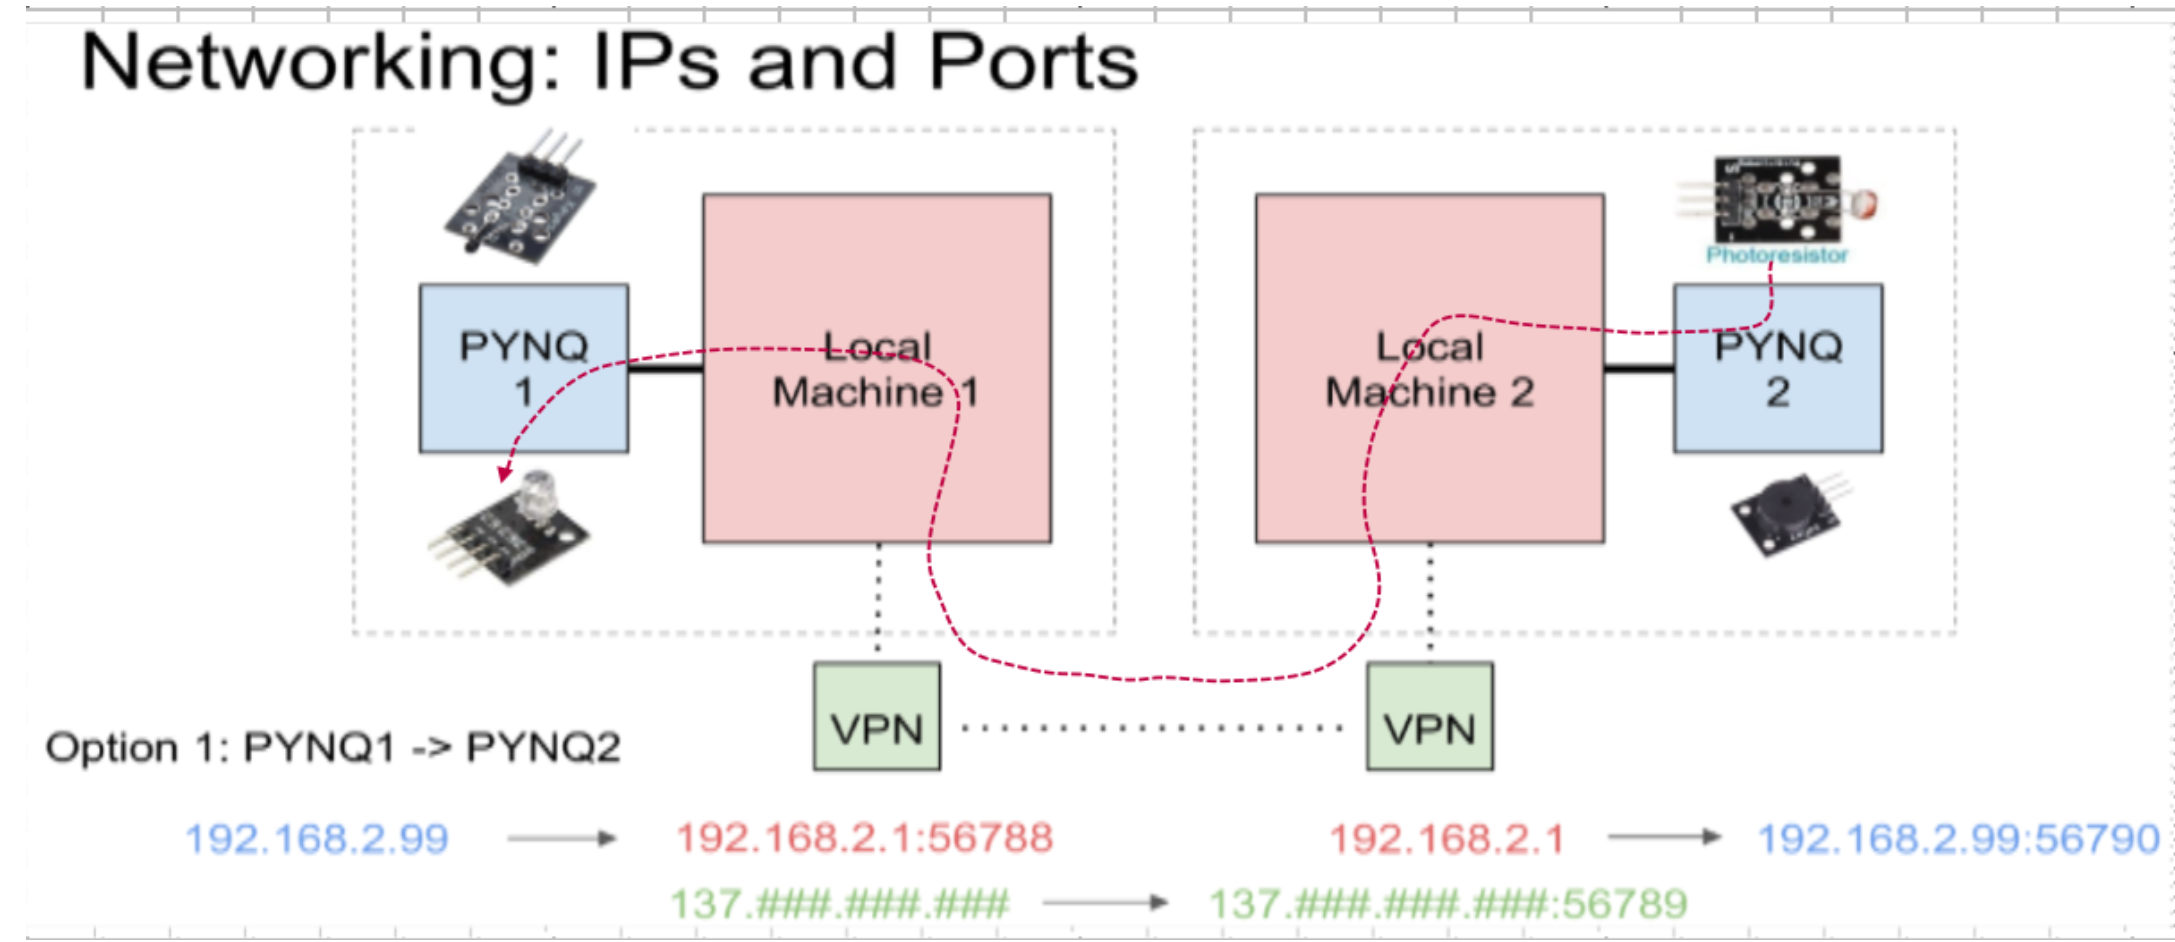

# PYNQ2 as client, photoresistor

In [ ]:
from pynq.lib import Pmod_ADC    # Pmod_ADC library

In [ ]:
adc = Pmod_ADC(base.PMODA)

reading = adc.read_raw(ch1=0, ch2=0, ch3=1)[0] # Get the raw value from the Pmod ADC.
print(reading)

In [ ]:
cond_c = True
start_c = 0
def runClient(i_cpu, ip, port, test):
    global cond_c, start_c
    
    print("Client running on CPU_{} connecting server @ ip {}:port {}...\n".format(i_cpu, ip, port))
    sock = socket.socket(socket.AF_INET, socket.SOCK_STREAM)

    # 1: Connect the socket (sock) to the <SERVER-IP> and choosen port <LISTENING-PORT>
    sock.connect((str(ip), port))
    

    # 2: Send messages
    t = threading.Thread(target=runBottonLoop_2, args=(test,))
    name = t.getName()
    t.start()
    
    condLoop = True
    start_c = 0
    while condLoop:
        time.sleep(0.1)
        bMsg = (str(start_c)+'\n').encode('ASCII')
        sock.send(bMsg)
        time.sleep(5)
        """
        if start == 0:
            time.sleep(0.3)
        if start == 1:
            time.sleep(0.3)
              
            bMsg = (str(start)+'\n').encode('ASCII')
            sock.send(bMsg)
            #print('Here', str(start)) 
            start = 0
            
        if start == 2:
            time.sleep(0.3)
            
            bMsg = (str(start)+'\n').encode('ASCII')
            sock.send(bMsg)
            #print('Here', str(start))
            start = 0

            
        if start == 4:    
            time.sleep(0.3)
            
            bMsg = (str(start)+'\n').encode('ASCII')
            sock.send(bMsg)
            #print('Here', str(start))
            start = 0          
            condLoop = False
        """
        
    print('{} joined'.format(name))
    t.join()
    
    # 3: Close the socket
    sock.close()

    
async def get_btns_2(_loop):
    global cond_c, start_c
    while cond_c:
        await asyncio.sleep(0.01)
        #print('cond')
        """
        if btns.read() == 1: # the first button on the very right
            start = 1
            await asyncio.sleep(0.3)
            print("pressing BTN0")
                    
        elif btns.read() == 2: # buzzer
            start = 2
            await asyncio.sleep(0.3)
            print("pressing BTN1")
       """
        if btns.read() == 8: # blinking blue led
            
            cond_c = False
            await asyncio.sleep(0.3)
            print('\n')
            print("pressing BTN3, stop the client")
            _loop.stop()

            
async def getPhotoResistance(test):
    global cond_c, start_c
    while cond_c:
        await asyncio.sleep(5)
        if test == False:
            reading = adc.read_raw(ch1=0, ch2=0, ch3=1)[0]  # This is where t replace with the reading from sensor
        reading = random.randint(0,4095)
        start_c = int(reading)
        print("start = ", start_c)
            
def runBottonLoop_2(test):
    loop = asyncio.new_event_loop()    # Create and return a new event loop object.
    loop.create_task(getPhotoResistance(test))
    loop.create_task(get_btns_2(loop))
    loop.run_forever()
    loop.close()   
    print("Exit loop...")

# unit test
runBottonLoop_2(True)

In [ ]:
# creating process, the first arg defines which CPU to run the 'target' on
i_cpu, ip, port, test = 1, '192.168.2.1', 50005, True
pC = multiprocessing.Process(target=runClient, args=(i_cpu, ip, port, test, ))

# Execute the command (a string) in a subshell,  
# taskset is an os command to pin the process to a specific CPU
os.system("taskset -p -c {} {}".format(i_cpu, pC.pid))

pC.start()          # start the process
procs.append(pC)
pCName = pC.name    # get process1 name

In [ ]:
for pO in procs:
    name = pO.name
    pO.join()
    print("{} joined.".format(name))